# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import missingno as msno
%matplotlib inline

## Подготовка данных

In [171]:
df = pd.read_csv('autos.csv')

In [172]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [173]:
df.shape

(354369, 16)

In [174]:
df = df.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gear_box',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'NotRepaired': 'not_repaired',
    'DateCreated': 'date_created', 
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen',
})
df.sample()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
263278,2016-03-19 03:48:08,18900,suv,2011,auto,140,tiguan,80000,9,gasoline,volkswagen,no,2016-03-18 00:00:00,0,71522,2016-03-31 11:46:23


In [175]:
df.isna().sum().sort_values(ascending=False)

not_repaired          71154
vehicle_type          37490
fuel_type             32895
gear_box              19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

### Проверка на дубликаты

In [176]:
df.duplicated().sum()

4

In [177]:
df.drop_duplicates(inplace=True)

In [178]:
df.duplicated().sum() == 0

True

Удалили 4 дубликата

### date_crawled - дата скачивания анкеты из базы

In [179]:
df['date_crawled']

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354364    2016-03-21 09:50:58
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: date_crawled, Length: 354365, dtype: object

In [180]:
pd.to_datetime(df['date_crawled']).dt.year.unique()

array([2016], dtype=int64)

In [181]:
pd.to_datetime(df['date_crawled']).dt.month.unique()

array([3, 4], dtype=int64)

In [182]:
pd.to_datetime(df['date_crawled']).dt.dayofweek.unique()

array([3, 0, 4, 5, 1, 6, 2], dtype=int64)

Видим, что у нас представлены даты скачивания анкет из базы за 2016 год, за 2 месяца и у нас представлены все дни недели.

In [183]:
df['date_crawled_month'] = df['date_crawled'].apply(lambda x: x[:7])

In [184]:
df.groupby('date_crawled_month')['price'].agg({'sum', 'mean'})

,mean,sum
date_crawled_month,,
2016-03,4383.829183,1301212562
2016-04,4586.128632,263904186


In [185]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Видим, что средняя цена за оба месяца практически равна средней по датасету

### vehicle_type - тип автомобильного кузова

In [186]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [187]:
df['vehicle_type'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [188]:
df[df['vehicle_type'].isna()].head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016-03
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,2016-04
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33,2016-03
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46,2016-03
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07,2016-03


В целом данные есть чем заполнить, например восстановить по модели

### registration_year - год регистрации автомобиля

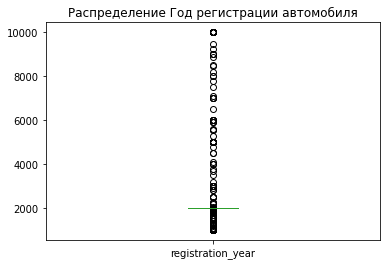

In [189]:
df['registration_year'].plot.box()
plt.title('Распределение Год регистрации автомобиля')
plt.show()

In [190]:
df[(df['registration_year'] > 2023) | (df['registration_year'] < 1900)]['registration_year']

622       1111
12946     5000
15147     9999
15870     3200
16062     1000
          ... 
340548    3500
340759    1600
341791    3000
348830    1000
351682    1800
Name: registration_year, Length: 171, dtype: int64

Есть некоторое количество неадекватных данных, их количество не критичное, возможно их можно будет обработать адекватным образом

In [191]:
df[~((df['registration_year'] > 2023) | (df['registration_year'] < 1950))].groupby('registration_year')['price'].agg({'sum', 'mean'})

,mean,sum
registration_year,,
1950,7411.888889,133414
1951,10588.833333,127066
1952,9176.666667,82590
1953,7643.214286,107005
1954,8144.454545,89589
...,...,...
2015,10986.650538,14304619
2016,2104.498073,20201077
2017,3031.650608,31653464


Можно сказать, что год регистрации имеет значение, но корреляция не линейная

In [192]:
year_labels = ['Долгожительная', 'Старая', 'Пожилая', 'Зрелая', 'Молодая', 'Юная']

df['registration_year_cut'] = pd.qcut(
    df['registration_year'],
    q=6,
    labels=year_labels,
)

In [193]:
df.sample(3)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut
204081,2016-03-23 22:57:07,500,wagon,1993,manual,116,passat,5000,4,NaN,volkswagen,NaN,2016-03-23 00:00:00,0,74842,2016-03-25 14:18:51,2016-03,Долгожительная
321844,2016-04-03 19:41:52,1850,wagon,2001,manual,110,octavia,150000,5,gasoline,skoda,no,2016-04-03 00:00:00,0,42489,2016-04-03 19:41:52,2016-04,Пожилая
287788,2016-03-11 18:45:34,15000,wagon,2012,manual,105,a3,80000,5,gasoline,audi,no,2016-03-11 00:00:00,0,85435,2016-04-05 20:17:46,2016-03,Юная


In [194]:
df.groupby('registration_year_cut')['price'].mean()

registration_year_cut
Долгожительная    1984.482378
Старая            1634.138814
Пожилая           2863.592495
Зрелая            5110.326988
Молодая           8461.610225
Юная              7384.273513
Name: price, dtype: float64

In [195]:
df['registration_year_cut'] = df['registration_year_cut'].astype(object)

### gear_box - тип коробки передач

In [196]:
df['gear_box'].value_counts()

manual    268249
auto       66283
Name: gear_box, dtype: int64

Тут все достаточно просто, 2 значения и есть пропуски, так же попробуем понять как их заполнить

In [197]:
df[~df['gear_box'].isna()].groupby(['gear_box', 'brand', 'model'])['gear_box'].agg({'count'})

count
gear_box brand      model          
auto     alfa_romeo 147          29
                    156          45
                    159          26
                    other        32
                    spider        3
...                             ...
manual   volvo      v40         674
                    v50         210
                    v60          26
                    v70         385
                    xc_reihe     68

[572 rows x 1 columns]

Например по медиане представленной модели

### power - мощность (л. с.)

In [198]:
df['power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [199]:
df[~((df['power'] > 60) & (df['power'] < 350))].head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016-03,Долгожительная
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58,2016-03,Долгожительная
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47,2016-03,Долгожительная
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,2016-04,Юная
23,2016-03-12 19:43:07,450,small,1997,manual,50,arosa,150000,5,petrol,seat,no,2016-03-12 00:00:00,0,9526,2016-03-21 01:46:11,2016-03,Долгожительная


In [200]:
pow_labels = ['Лиса', 'Косуля', 'Зайка', 'Антилопа', 'Пантера', 'Ракета']

df['power_cut'] = pd.qcut(
    df['power'],
    q=6,
    labels=pow_labels,
)

In [201]:
df.sample(1)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
206446,2016-03-17 15:25:23,900,small,1998,auto,54,corsa,70000,3,petrol,opel,no,2016-03-17 00:00:00,0,56288,2016-03-20 11:48:40,2016-03,Старая,Лиса


In [202]:
df.groupby('power_cut')['price'].mean()

power_cut
Лиса        1964.341173
Косуля      2163.703420
Зайка       3854.918804
Антилопа    4254.008747
Пантера     6055.078314
Ракета      8542.878638
Name: price, dtype: float64

In [203]:
df['power_cut'].value_counts()

Зайка       66789
Пантера     62952
Косуля      60938
Лиса        59275
Ракета      54564
Антилопа    49847
Name: power_cut, dtype: int64

In [204]:
df['power_cut'] = df['power_cut'].astype(str)

### model - модель автомобиля

In [205]:
df.groupby('model')['price'].agg({'mean'}).reset_index().sort_values('mean')

,model,mean
96,elefantino,522.636364
138,lanos,602.191011
155,move,606.366667
195,samara,680.307692
144,lybra,768.203704
...,...,...
184,range_rover_sport,15332.796296
30,a5,15531.853211
178,q5,15843.989691
115,glk,16057.515625


In [206]:
df['model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

Средняя стоимость автомобиля зависит от модели. Так же надо заполнить пропуски

### kilometer - пробег (км)

In [207]:
df['kilometer'].describe()

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Здесь не вижу критичных значений, пропусков нет.

### registration_month - месяц регистрации автомобиля

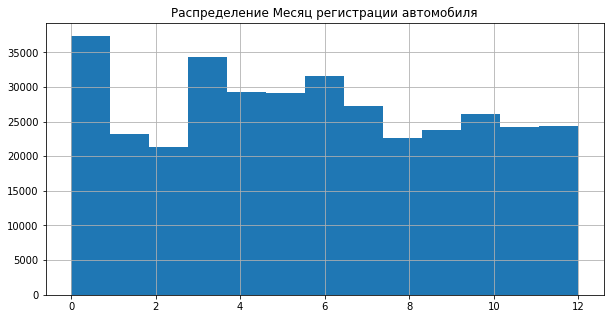

In [208]:
plt.figure(figsize=(10, 5))
plt.title("Распределение Месяц регистрации автомобиля")
df['registration_month'].hist(bins=13)
plt.show()

Без аномалий

### fuel_type - тип топлива

In [209]:
df.groupby('fuel_type')['price'].agg({'mean', 'count', 'median'})

,count,median,mean
fuel_type,,,
cng,565,3650.0,4464.661947
electric,90,5799.5,6657.711111
gasoline,98719,5200.0,6579.806542
hybrid,233,9990.0,9465.356223
lpg,5310,2983.5,4040.089831
other,204,974.5,2312.029412
petrol,216349,2000.0,3750.041775


Чаще всего встречаются типы petrol и gasolin, при этом средняя и медиана самые высокие в hybrid. Еще есть тип electric - их мало, но они дорогие, это будет особый сегмент

### brand - марка автомобиля

In [210]:
df.groupby('brand')['price'].agg({'mean', 'count', 'median'})

,count,median,mean
brand,,,
alfa_romeo,2314,2200.0,3697.622731
audi,29456,4600.0,6239.976507
bmw,36914,4799.0,6162.214661
chevrolet,1754,4000.0,5639.312429
chrysler,1439,2200.0,3710.838777
citroen,5148,2497.0,3467.194639
dacia,900,4800.0,5839.654444
daewoo,542,999.0,1017.811808
daihatsu,806,999.0,1693.656328


У нас чаще всего встречаются volkswagen, они в среднем ценовом сегменте; среди дорогих выделяются porsche, mini и land rover - они самые дорогие и их не так много

### not_repaired - была машина в ремонте или нет

In [211]:
df['not_repaired'].value_counts()

no     247158
yes     36053
Name: not_repaired, dtype: int64

Здесь всего 2 значения и есть пропуски, в этом случае можно предположить что отсутствие данных о ремонте является его отсутствием

### date_created - дата создания анкеты

In [212]:
pd.to_datetime(df['date_created']).dt.year.unique()

array([2016, 2015, 2014], dtype=int64)

In [213]:
pd.to_datetime(df['date_created']).dt.month.unique()

array([ 3,  4,  2,  1, 11, 12,  9,  8,  6], dtype=int64)

In [214]:
df['date_created'].min(), df['date_created'].max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

Даты создания анкеты у нас за 2 года с 2014. У нас нет наблюдений за май, июль, октябрь.

### number_of_pictures - количество фотографий автомобиля

In [215]:
df['number_of_pictures'].unique()

array([0], dtype=int64)

Здесь только одно значение, значит фичу можно смело удалять

### postal_code - почтовый индекс владельца анкеты (пользователя)

In [216]:
df['postal_code'].unique()

array([70435, 66954, 90480, ..., 38528, 38325, 31096], dtype=int64)

In [217]:
df[['postal_code', 'price']].corr()

,postal_code,price
postal_code,1.000000,0.076058
price,0.076058,1.000000


Как и предполагалось, линейной зависимости между почтовым индексом и ценой нет, мы еще позже проверим насколько эта фича важна нам

### last_seen - дата последней активности пользователя

In [218]:
pd.to_datetime(df['last_seen']).dt.year.unique()

array([2016], dtype=int64)

In [219]:
pd.to_datetime(df['last_seen']).dt.month.unique()

array([4, 3], dtype=int64)

Здесь уникальность значений похожа на date_crawled

### price - цена

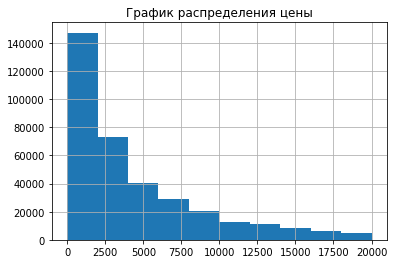

In [220]:
df['price'].hist()
plt.title("График распределения цены")
plt.show()

In [221]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [222]:
zero_price = df[df['price'] == 0].shape[0]
df[df['price'] == 0]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58,2016-03,Долгожительная,Лиса
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34,2016-03,Долгожительная,Лиса
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05,2016-03,Юная,Лиса
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22,2016-03,Старая,Лиса
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10,2016-03,Зрелая,Зайка
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08,2016-03,Старая,Косуля
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23,2016-03,Пожилая,Косуля
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24,2016-03,Старая,Лиса
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32,2016-03,Старая,Лиса


In [223]:
print(f"Процент наблюдений с нулевой ценой: {zero_price/df.shape[0] * 100.:.2f}%")

In [224]:
df.loc[df['price'] == 0] = np.nan

Сбросили цену до нуля что бы заполнить ее модой

### Обработка неадекватных значений

In [225]:
df[(df['registration_year'] > 2023) | (df['registration_year'] < 1900)]['registration_year'].head()

12946    5000.0
15870    3200.0
16062    1000.0
17271    9999.0
17346    8888.0
Name: registration_year, dtype: float64

In [226]:
miss_len = df[(df['registration_year'] > 2023) | (df['registration_year'] < 1900)].shape[0]
print(f"Процент наблюдений с максимальным пропуском: {miss_len/df.shape[0] * 100.:.2f}%")

In [227]:
df = df[~((df['registration_year'] > 2023) | (df['registration_year'] < 1900))]

### Визуализация и работа с пропусками

Text(0.5, 1.0, 'Визуализация пропусков')

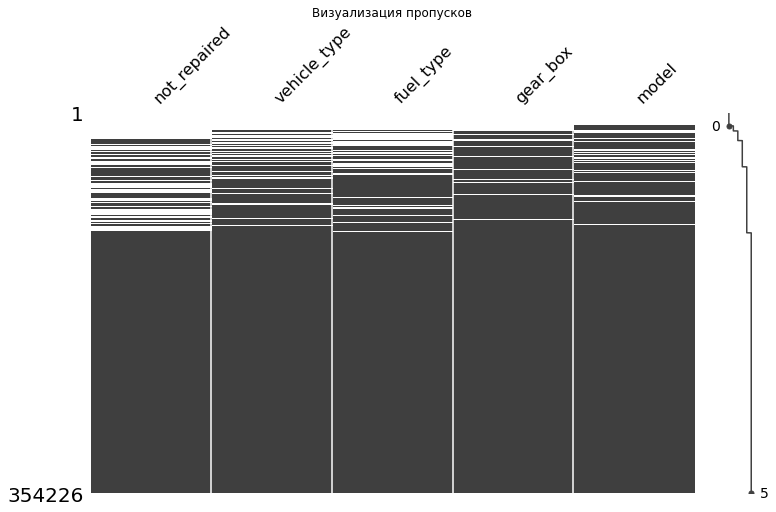

In [228]:
msno.matrix(
    df[['not_repaired',
        'vehicle_type',
        'fuel_type',
        'gear_box',
        'model']],
    figsize=(12, 7),
    sort='ascending',
)
plt.title("Визуализация пропусков")

Text(0.5, 1.0, 'Матрица корреляций пропусков')

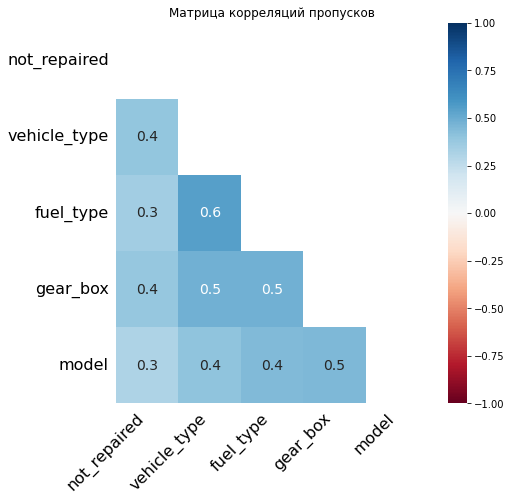

In [229]:
msno.heatmap(
    df[['not_repaired',
        'vehicle_type',
        'fuel_type',
        'gear_box',
        'model']],
    figsize=(7, 7),
)
plt.title("Матрица корреляций пропусков")

Видим, что у нас есть взаимосвязь пропусков, например 40% наблюдений, имеющих пропуски в fuel_type имеют пропуск в vehicle_type

<AxesSubplot:>

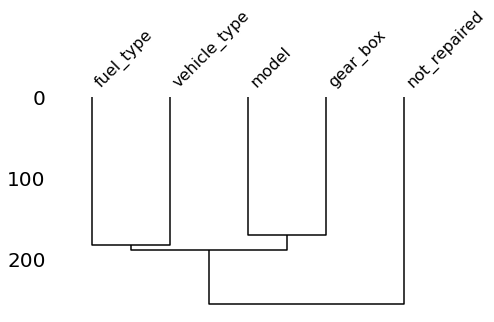

In [230]:
msno.dendrogram(
    df[['not_repaired',
        'vehicle_type',
        'fuel_type',
        'gear_box',
        'model']],
    figsize=(7, 4),
)

Еще лучше видны взаимосвязи пропусков.
Здесь можно сделать вывод, что наблюдения с взаимосвязанными пропусками будет сложнее восстановить. Посмотрим их количество

In [231]:
miss_len = df[df['fuel_type'].isna() & df['vehicle_type'].isna() & df['model'].isna() & df['gear_box'].isna()].shape[0]
df[df['fuel_type'].isna() & df['vehicle_type'].isna() & df['model'].isna() & df['gear_box'].isna()]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
print(f"Процент наблюдений с максимальным пропуском: {miss_len/df.shape[0] * 100.:.2f}")

Процент наблюдений с максимальным количеством пропусков меньше 1, что в целом дает нам право пожертвовать этими наблюдениями, так как мы можем иначе создать больше шума в данных.

In [233]:
df_fisrt_clen = df[~(df['fuel_type'].isna() & df['vehicle_type'].isna() & df['model'].isna() & df['gear_box'].isna())]

In [234]:
df_fisrt_clen

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
0,2016-03-24 11:52:17,480.0,NaN,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57,2016-03,Долгожительная,Лиса
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50,2016-03,Юная,Ракета
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46,2016-03,Зрелая,Пантера
3,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17,2016-03,Пожилая,Косуля
4,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21,2016-03,Молодая,Косуля
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,2016-03-19 19:53:49,3200.0,sedan,2004.0,manual,225.0,leon,150000.0,5.0,petrol,seat,yes,2016-03-19 00:00:00,0.0,96465.0,2016-03-19 20:44:43,2016-03,Зрелая,Ракета
354363,2016-03-27 20:36:20,1150.0,bus,2000.0,manual,0.0,zafira,150000.0,3.0,petrol,opel,no,2016-03-27 00:00:00,0.0,26624.0,2016-03-29 10:17:23,2016-03,Старая,Лиса
354366,2016-03-05 19:56:21,1199.0,convertible,2000.0,auto,101.0,fortwo,125000.0,3.0,petrol,smart,no,2016-03-05 00:00:00,0.0,26135.0,2016-03-11 18:17:12,2016-03,Старая,Зайка
354367,2016-03-19 18:57:12,9200.0,bus,1996.0,manual,102.0,transporter,150000.0,3.0,gasoline,volkswagen,no,2016-03-19 00:00:00,0.0,87439.0,2016-04-07 07:15:26,2016-03,Долгожительная,Зайка


In [235]:
miss_len = df[df['fuel_type'].isna() & df['vehicle_type'].isna()].shape[0]
df[df['fuel_type'].isna() & df['vehicle_type'].isna()]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2016-03-10 19:38:18,5555.0,NaN,2017.0,manual,125.0,c4,125000.0,4.0,NaN,citroen,no,2016-03-10 00:00:00,0.0,31139.0,2016-03-16 09:16:46,2016-03,Юная,Антилопа
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2016-04-04 10:57:36,1400.0,NaN,2016.0,manual,55.0,other,5000.0,1.0,NaN,hyundai,NaN,2016-04-04 00:00:00,0.0,34454.0,2016-04-06 12:45:43,2016-04,Юная,Лиса
57,2016-03-10 20:53:19,2399.0,NaN,2018.0,manual,64.0,other,125000.0,3.0,NaN,seat,no,2016-03-10 00:00:00,0.0,33397.0,2016-03-25 10:17:37,2016-03,Юная,Косуля
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600.0,NaN,2005.0,auto,0.0,c_klasse,150000.0,9.0,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0.0,61169.0,2016-03-08 21:28:38,2016-03,Зрелая,Лиса
354351,2016-03-11 23:40:32,1900.0,NaN,2000.0,manual,110.0,NaN,150000.0,7.0,NaN,volkswagen,no,2016-03-11 00:00:00,0.0,87700.0,2016-03-12 14:16:51,2016-03,Старая,Антилопа
354361,2016-03-09 13:37:43,5250.0,NaN,2016.0,auto,150.0,159,150000.0,12.0,NaN,alfa_romeo,no,2016-03-09 00:00:00,0.0,51371.0,2016-03-13 01:44:13,2016-03,Юная,Пантера
354364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
print(f"Процент наблюдений с пропусками в fuel_type и vehicle_type: {miss_len/df.shape[0] * 100.:.2f}")

In [237]:
miss_len = df[df['model'].isna() & df['gear_box'].isna()].shape[0]
df[df['model'].isna() & df['gear_box'].isna()]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,date_crawled_month,registration_year_cut,power_cut
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,2016-03-27 20:47:22,6799.0,small,2009.0,NaN,60.0,NaN,20000.0,5.0,petrol,volkswagen,no,2016-03-27 00:00:00,0.0,89077.0,2016-03-27 20:47:22,2016-03,Молодая,Косуля
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354338,2016-03-31 19:52:33,180.0,NaN,1995.0,NaN,0.0,NaN,125000.0,3.0,petrol,opel,NaN,2016-03-31 00:00:00,0.0,41470.0,2016-04-06 14:18:04,2016-03,Долгожительная,Лиса
354364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
print(f"Процент наблюдений с пропусками в model и gear_box: {miss_len/df.shape[0] * 100.:.2f}")

In [239]:
df_second_clean = df_fisrt_clen[~(df_fisrt_clen['model'].isna() & df_fisrt_clen['gear_box'].isna())]

Удалили пропуски которые составляли около 1%, остальные оставили, их больше - около 5%

In [240]:
df_second_clean.shape

(340416, 19)

### Обработка пропусков

In [241]:
def fill_miss_values(df):
    # фичу была ли машина в ремонте заполним 'no' - как предположительно самое очевидное
    df.fillna(value={'not_repaired': 'no'}, inplace=True)

    # v2. заполнение пропусков средним значением цены машины в группе бренд-модель-год
    df["price"] = df.groupby(['brand', 'model', 'registration_year'])["price"].transform(lambda x: x.fillna(x.mean()))

    # заполнение пропусков в группе бренд-модель-тип кузова-тип топлива
    df = df.groupby(['brand', 'model', 'vehicle_type', 'fuel_type']).\
        apply(lambda x: x.fillna(x.mode().iloc[0])).reset_index(drop=True)
    # еще один прогон, в рамках того, что не все группы показывают пример заполнения, уберем fuel_type
    df = df.groupby(['brand', 'model', 'vehicle_type']).\
        apply(lambda x: x.fillna(x.mode().iloc[0])).reset_index(drop=True)

    # еще один прогон, в рамках того, что не все группы показывают пример заполнения, уберем vehicle_type
    df = df.groupby(['brand', 'model']).\
        apply(lambda x: x.fillna(x.mode().iloc[0])).reset_index(drop=True)

    return df

In [242]:
%%time

df_third_fillna = fill_miss_values(df_second_clean)

In [243]:
df_third_fillna.isna().sum().sum()

0

### Преобразование типов и создание новых фичей

In [244]:
def feature_engineering(df):
    # Переведем булевы переменные
    df['not_repaired'] = df['not_repaired'].apply(lambda x: 1 if x == "yes" else 0)
    df['gear_box'] = df['gear_box'].apply(lambda x: 1 if x == "auto" else 0)

    # Преобразование даты
    df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
    df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
    df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

    # Добавление дополнительных фичей
    df['date_created_month'] = pd.DatetimeIndex(df['date_created']).month
    df['date_created_year'] = pd.DatetimeIndex(df['date_created']).year

    df['date_crawled_month'] = pd.DatetimeIndex(df['date_crawled']).month
    df['date_crawled_dayofweek'] = pd.DatetimeIndex(df['date_crawled']).dayofweek

    df['last_seen_month'] = pd.DatetimeIndex(df['last_seen']).month
    df['last_seen_dayofweek'] = pd.DatetimeIndex(df['last_seen']).dayofweek

    # Модели машин, которые совсем редко встречаются
    model_less_20 = df['model'].value_counts().reset_index().query("model < 20")['index'].to_list()
    df['model'] = df['model'].apply(lambda x: 'other_2' if x in model_less_20 else x)

    # Удаление ненужных/переработанных фичей
    df.drop(columns=['date_created', 'date_crawled', 'last_seen', 'number_of_pictures', 'date_crawled_month'], inplace=True)

    return df

In [245]:
df_fourth_engineering = feature_engineering(df_third_fillna)

In [246]:
%%time

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :", start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings

            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)

            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

                # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            try:
                result = (props[col] - asint)
                result = result.sum()
                if result > -0.01 and result < 0.01:
                    IsInt = True

                # Make Integer/unsigned Integer datatypes
                if IsInt:
                    if mn >= 0:
                        if mx < 255:
                            props[col] = props[col].astype(np.uint8)
                        elif mx < 65535:
                            props[col] = props[col].astype(np.uint16)
                        elif mx < 4294967295:
                            props[col] = props[col].astype(np.uint32)
                        else:
                            props[col] = props[col].astype(np.uint64)
                    else:
                        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                            props[col] = props[col].astype(np.int8)
                        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                            props[col] = props[col].astype(np.int16)
                        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                            props[col] = props[col].astype(np.int32)
                        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                            props[col] = props[col].astype(np.int64)

                            # Make float datatypes 32 bit
                else:
                    props[col] = props[col].astype(np.float32)

                # Print new column type
                print("dtype after: ",props[col].dtype)
                print("******************************")
            except TypeError:
                pass

    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df_fourth_engineering, NAlist = reduce_mem_usage(df_fourth_engineering)

Преобразовали типы данных даты
Создали новые фичи из них
Один столбец перевели из категориальных фичей в булевы
Удалили все ненужные столбцы
Сократили объем памяти датасета

## Обучение моделей

### Разбиение на test и train

In [247]:
RANDOM_STATE = 13
X = df_fourth_engineering.drop(columns='price')
y = df_fourth_engineering['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [248]:
X_train.shape, X_test.shape

((228760, 18), (57190, 18))

### Подготовим функцию для вывода отчета

In [249]:
import time

final_report = {}

def rmse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} s'.format(f.__name__, (time2-time1)))
        return ret
    return wrap

@timing
def fit_model(estimator, X_train, y_train):
    estimator.fit(X_train, y_train)
    return estimator

@timing
def predict_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = rmse_score(y_test, y_pred)
    print(f"RMSE: {rmse}")
    return model, rmse

In [ ]:
cat_features = ['vehicle_type', 'model', 'fuel_type', 'brand', 'power_cut', 'registration_year_cut']

### CatBoostRegressor

In [253]:
model = fit_model(
    CatBoostRegressor(cat_features=cat_features, verbose=200, random_state=RANDOM_STATE),
    X_train,
    y_train,
)
catboost_model, final_report['CatBoostRegressor_rmse'] = predict_model(
    model,
    X_test,
    y_test,
)

### LGBMRegressor

In [254]:
X_train = pd.get_dummies(X_train, columns=cat_features)
X_test = pd.get_dummies(X_test, columns=cat_features)
# проверка что у нас равное количество колонок
assert X_train.shape[1] == X_test.shape[1], f"Не равное количество колонок на тесте и трейне: " \
                                            f"{list(set(X_train.columns) - set(X_test.columns))}"

In [255]:
model = fit_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    X_train,
    y_train,
)
lgbm_model, final_report['LGBMRegressor_rmse'] = predict_model(
    model,
    X_test,
    y_test,
)

### RandomForestRegressor

In [256]:
model = fit_model(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    X_train,
    y_train,
)
rfr_model, final_report['RandomForestRegressor_rmse'] = predict_model(
    model,
    X_test,
    y_test,
)

In [257]:
final_report

{'CatBoostRegressor_rmse': 1520.04103449754,
 'LGBMRegressor_rmse': 1632.723642417455,
 'RandomForestRegressor_rmse': 1510.214058308401}

v2. После преобразования power, а также таргета мы значительно улучшили метрики + было немного изменено заполнение карт фичей(добавлен год при группировке).

### Feature importances

In [258]:
fi = pd.DataFrame(lgbm_model.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False)

,importance
registration_year,510
power,482
kilometer,194
brand_audi,78
vehicle_type_convertible,74
...,...
model_jetta,0
model_jimny,0
model_juke,0
model_justy,0


Так как опираемся на модель lightGBM, то оценим важные признаки, есть признаки, которые не имеют влияния и создают шум, уберем их:

In [259]:
del_features = fi[fi['importance'] == 0]['importance'].index.tolist()

In [260]:
X_train_short = X_train.drop(columns=del_features)
X_test_short = X_test.drop(columns=del_features)

In [261]:
len(X_train.columns), len(X_train_short.columns)

(313, 142)

Отлично, сократили датасет почти в 2 раза, проверим как изменится качество

In [262]:
model = fit_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    X_train_short,
    y_train,
)
lgbm_model, final_report['LGBMRegressor_rmse'] = predict_model(
    model,
    X_test_short,
    y_test,
)

Отлично, это никак не сказалось на качестве модели и немного сократили время, если бы данных было очень много, это бы могло сэкономить еще больше

### GridSearchCV CatBoost

In [272]:
%%time

cbr_grid = CatBoostRegressor(verbose=200, random_state=RANDOM_STATE)
grid = {
    'learning_rate': [0.1],
    'depth': [8],
    'l2_leaf_reg': [1],
}

grid_search_result = cbr_grid.grid_search(
    grid,
    X=X_train,
    y=y_train,
)

In [ ]:
grid_search_result

In [264]:
%%time
y_pred = cbr_grid.predict(X_test)
final_report['CatBoostRegressor_gscv_rmse'] = rmse_score(y_test, y_pred)

### GridSearchCV LGBMRegressor

In [ ]:
# params = {
#     'num_leaves': [7, 14, 21, 28, 31, 50],
#     'learning_rate': [0.1, 0.03, 0.003],
#     'max_depth': [-1, 3, 5],
#     'n_estimators': [50, 100, 200, 500],
# }
#
# grid = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE), params, scoring='neg_mean_squared_error', cv=5)
# grid.fit(X_train_short, y_train)

In [265]:
%%time
# grid.best_params_ {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}

lgbm = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=50, n_jobs=-1)
lgbm.fit(X_train_short, y_train)

LGBMRegressor(n_estimators=500, num_leaves=50, random_state=13)

In [267]:
%%time
y_pred = lgbm.predict(X_test_short)
final_report['LGBMRegressor_rmse_short_grid'] = rmse_score(y_test, y_pred)

### GridSearchCV RandomForestRegressor

In [189]:
# params = {
#     'max_depth': [15, 30],
#     'n_estimators': [120, 400],
# }
#
# grid = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), params, scoring='neg_mean_squared_error', cv=3)
# grid.fit(X_train_short, y_train)
# grid.best_params_
# {'max_depth': 30, 'n_estimators': 400}

{'max_depth': 30, 'n_estimators': 400}

In [268]:
%%time

rfr = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=30, n_estimators=400, n_jobs=-1)
rfr.fit(X_train_short, y_train)

RandomForestRegressor(max_depth=30, n_estimators=400, n_jobs=-1,
                      random_state=13)

In [271]:
%%time

y_pred = rfr.predict(X_test_short)
final_report['RandomForestRegressor_rmse_short_grid'] = rmse_score(y_test, y_pred)

In [270]:
final_report

{'CatBoostRegressor_rmse': 1520.04103449754,
 'LGBMRegressor_rmse': 1632.723642417455,
 'RandomForestRegressor_rmse': 1510.214058308401,
 'CatBoostRegressor_gscv_rmse': 1480.509739037389,
 'LGBMRegressor_rmse_short_grid': 1485.788099714344,
 'RandomForestRegressor_rmse_short_grid': 1509.4286304114084}

## Анализ моделей

- Обучили 3 модели без дополнительных гиперпараметров: CatBoostRegressor, LGBMRegressor, RandomForestRegressor
- По времени лучше всего себя показала LGBMRegressor, хуже всего - RandomForestRegressor, при чем отрыв значительный
- После проведения анализа важности фичей оставили только фичи, влияющие на качество модели, построили модель еще раз, качество не изменилось(изменение в тысячных долях). Количество фичей убавилось больше чем в 2 раза
- С помощью GridSearchCV подобрали оптимальные параметры, построили модели снова. Они показал улучшенный результат. Если добавить  n_jobs=-1 время улучшается

- По итогу добавлены категории для power и registration_year - это сразу улучшило метрики
- Обработали price - нули заменили на среднее в группе бренд-модель-год
По времени работы:
- CatBoostRegressor - ~2 мин на обучение, ~0.06 сек на предсказание
- LGBMRegressor - ~4 сек на обучение, ~1 сек на предсказание
- RandomForestRegressor - ~7 минут, ~3 секунды
По времени лидирует LGBMRegressor со значительным превосходством
По качеству модели(RMSE):
- Лучший результат показала модель CatBoostRegressor, а LGBMRegressor так же рядом: 1480 и 1485 соотв-но, RandomForestRegressor показал худший результат по метрике как и время
